In [1]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit,ShuffleSplit

In [2]:
import sys
sys.path.insert(0, '/data/src')
from features import geopatches

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [4]:
# prepare models
models = []
#models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))
#models.append(('GBC', GradientBoostingClassifier()))
#models.append(('XGB', XGBClassifier()))

In [5]:
def evaluate_model(list_img,dict_img,list_label,dict_label,scoring):

    np.random.seed(42)

    X_raw, Y_raw = geopatches.create_data(list_img,dict_img,\
                                        list_label,dict_label)
    #                                     ndvi={'nir': 4, 'red': 3}, evi={'nir':4, 'red': 3, 'blue': 1})

    #remove classes that are too small
    list_remove = []
    for x in np.asarray(np.unique(Y_raw, return_counts=True)).T:
        if x[1] < 400:
            list_remove.append(x[0])
    idx = np.arange(Y_raw.shape[0])[np.in1d(Y_raw,list_remove)]
    X_raw = np.delete(X_raw,idx,0)
    Y_raw = np.delete(Y_raw,idx,0)

    # Condition X
    X = X_raw.reshape([X_raw.shape[0],-1])
    Y = Y_raw.reshape([X_raw.shape[0],-1])

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3)
    #sss = ShuffleSplit(n_splits=1, random_state=42, test_size=0.3)
    train_index, test_index = next(sss.split(X,Y_raw.flatten()))

    X_train = X[train_index]
    Y_train = Y[train_index]

    X_test = X[test_index]
    Y_test = Y[test_index]

    # evaluate each model in turn
    results = []
    names = []
    #scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.StratifiedShuffleSplit(n_splits=10, random_state=42)
        cv_results = model_selection.cross_val_score(model, X, Y.flatten(), cv=kfold, scoring=scoring, n_jobs=-1)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # boxplot algorithm comparison
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

In [6]:
def f1_report(list_img,dict_img,list_label,dict_label):
    np.random.seed(42)

    X_raw, Y_raw = geopatches.create_data(list_img,dict_img,\
                                        list_label,dict_label)
    #                                     ndvi={'nir': 4, 'red': 3}, evi={'nir':4, 'red': 3, 'blue': 1})

    #remove classes that are too small
    list_remove = []
    for x in np.asarray(np.unique(Y_raw, return_counts=True)).T:
        if x[1] < 400:
            list_remove.append(x[0])
    idx = np.arange(Y_raw.shape[0])[np.in1d(Y_raw,list_remove)]
    X_raw = np.delete(X_raw,idx,0)
    Y_raw = np.delete(Y_raw,idx,0)

    # Condition X
    X = X_raw.reshape([X_raw.shape[0],-1])
    Y = Y_raw.reshape([X_raw.shape[0],-1])

    sss = StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2)
    #sss = ShuffleSplit(n_splits=1, random_state=42, test_size=0.3)
    train_index, test_index = next(sss.split(X,Y_raw.flatten()))
    
    model = RandomForestClassifier(oob_score=True)
    model.fit(X[train_index], Y_raw.flatten()[train_index])
    predicted = model.predict(X[test_index])
    accuracy = accuracy_score(Y.flatten()[test_index], predicted)
    
    print('Out-of-bag score estimate:', model.oob_score_)
    print('Mean accuracy score:', accuracy)
    
    print(classification_report(Y.flatten()[test_index], predicted))


LDA: 0.342513 (0.002679)
RF: 0.352442 (0.003535)
NB: 0.154825 (0.002637)


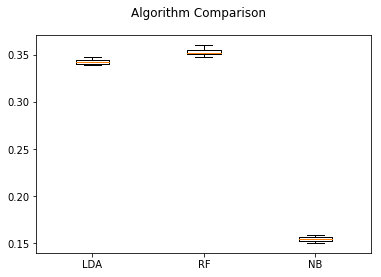

In [24]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140EVT_020818_UTM11_30_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1}, 'accuracy')

LDA: 0.543965 (0.002629)
RF: 0.551482 (0.002883)
NB: 0.329299 (0.006951)


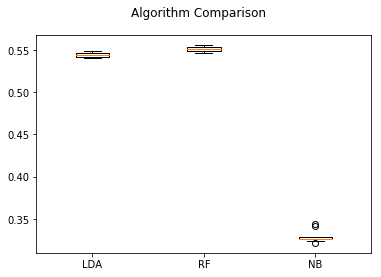

In [25]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140FBFM13_3030_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1}, 'accuracy')

LDA: 0.555678 (0.002420)
RF: 0.565025 (0.003906)
NB: 0.425629 (0.002491)


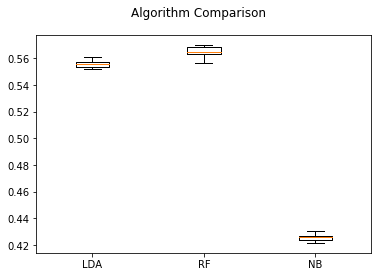

In [26]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/escondido_landcover_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1}, 'accuracy')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

LDA: 0.279130 (0.002175)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RF: 0.316097 (0.003534)
NB: 0.154557 (0.002538)


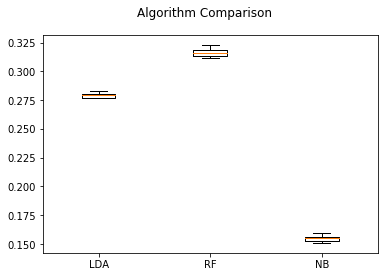

In [27]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140EVT_020818_UTM11_30_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1},'f1_weighted')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

LDA: 0.502661 (0.002524)
RF: 0.524842 (0.002959)
NB: 0.337047 (0.004923)


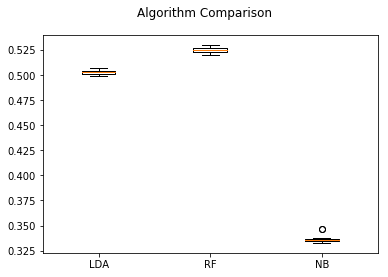

In [28]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140FBFM13_3030_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1},'f1_weighted')

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

LDA: 0.517224 (0.002331)


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RF: 0.543193 (0.003551)
NB: 0.419532 (0.002412)


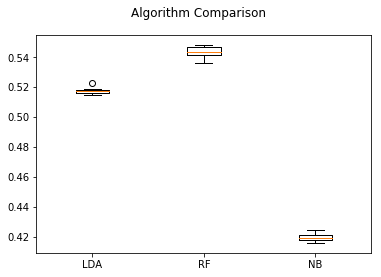

In [29]:
evaluate_model(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/escondido_landcover_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1},'f1_weighted')

In [11]:
f1_report(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140EVT_020818_UTM11_30_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1})

Out-of-bag score estimate: 0.29248039740904885
Mean accuracy score: 0.34983766233766234
             precision    recall  f1-score   support

       3092       0.37      0.55      0.44      4532
       3097       0.06      0.02      0.03       248
       3099       0.07      0.01      0.02       225
       3110       0.25      0.10      0.15       925
       3118       0.19      0.12      0.14       681
       3129       0.48      0.62      0.54      5847
       3130       0.00      0.00      0.00       192
       3152       0.32      0.23      0.27       172
       3184       0.18      0.13      0.15      1096
       3292       0.82      0.94      0.88       401
       3294       0.14      0.04      0.07       257
       3296       0.26      0.40      0.31      3502
       3297       0.40      0.52      0.45      3173
       3298       0.39      0.27      0.32       651
       3299       0.20      0.13      0.16      3063
       3900       0.24      0.08      0.12       119
       390

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [12]:
f1_report(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/US_140FBFM13_3030_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1})

Out-of-bag score estimate: 0.47817242492734907
Mean accuracy score: 0.5519535033903777
             precision    recall  f1-score   support

          1       0.48      0.59      0.53      8543
          2       0.21      0.09      0.13      3389
          4       0.13      0.01      0.03       417
          5       0.54      0.53      0.54      5849
          8       0.30      0.14      0.19      1000
          9       0.30      0.18      0.22       746
         91       0.67      0.77      0.72     10355
         98       0.85      0.90      0.87       402
         99       0.40      0.02      0.04       269

avg / total       0.52      0.55      0.53     30970



/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [13]:
f1_report(['/data/conditioned/planetlabs/1154314_2014-07-23_RE2_3A_Analytic_clip.tif'],\
               {'width': 6, 'height': 6, 'stride': 6, 'padding': 0},\
               ['/data/conditioned/landfire/escondido_landcover_clipped.tif'],\
              {'width': 1, 'height': 1, 'stride': 1})

Out-of-bag score estimate: 0.5048937790669411
Mean accuracy score: 0.567085817993259
             precision    recall  f1-score   support

         11       0.84      0.93      0.88       500
         21       0.40      0.49      0.44      6748
         22       0.35      0.31      0.33      4529
         23       0.55      0.59      0.57      3990
         24       0.51      0.29      0.37       864
         31       0.23      0.03      0.06       307
         43       0.25      0.01      0.03       135
         52       0.76      0.85      0.80     11061
         71       0.31      0.10      0.16      2355
         82       0.52      0.14      0.22       239
         90       0.30      0.02      0.04       128

avg / total       0.54      0.57      0.55     30856



/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
